In [1]:
import cv2
import numpy as np
import requests
from itertools import product
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = (12,8)
%matplotlib inline

# HW2: Object Detection, Tracking and Segmentation

In the last few weeks we've looked at different methods to approach image and scene understading on the object level. We spoke of:
- object detection, how to find objects in the scene, then 
- object tracking, how to track a moving object through time, and finally
- segmentation, how to precisely segmenet objects from one another or the scene background

So far we've seen early methods for these matters, and we will revisit them with fresh eyes as we move into machine learning based computer vision, and particularly that using deep neural networks.

One of the eraliest methods for object detection we've seen is **Template Matching**.

Consider frames $k$ and $k+1$ from this clip:

In [2]:
im1 = cv2.imdecode(np.frombuffer(requests.get("https://drive.google.com/uc?id=14fKPM2Ka-nFvD9i6qzUes0Kop_zC2wgO").content, np.uint8), cv2.IMREAD_COLOR)[...,::-1]
im2 = cv2.imdecode(np.frombuffer(requests.get("https://drive.google.com/uc?id=1OoT1BLJFuAL5JSmn3nLWA4FVeLspj13Q").content, np.uint8), cv2.IMREAD_COLOR)[...,::-1]

In [3]:
p = im1[35:75,72:112]

In [4]:
im1g = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
im2g = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)
pg = cv2.cvtColor(p,cv2.COLOR_BGR2GRAY)

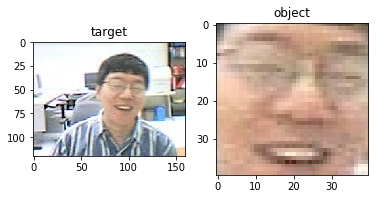

In [5]:
plt.subplot(121),plt.imshow(im2),plt.title('target')
plt.subplot(122),plt.imshow(p),plt.title('object');

Now let's find the face in frame $k$ and try to find it in frame $k+1$ using template matching based on SSD

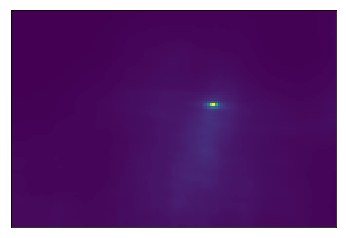

In [6]:
plt.imshow(1./cv2.matchTemplate(im2g, pg, cv2.TM_SQDIFF))
plt.xticks([]),plt.yticks([]);

If we change frame $k+1$'s intesity value and try again - it doesn't work as well.

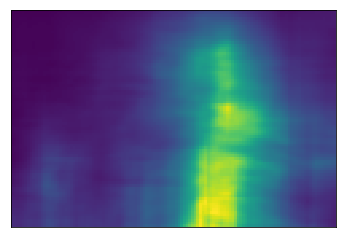

In [7]:
plt.imshow(1./cv2.matchTemplate(im2g + 50, pg, cv2.TM_SQDIFF))
plt.xticks([]),plt.yticks([]);

----

## Here comes your part

<img src="https://i0.wp.com/wordsporn.com/wp-content/uploads/2018/02/1519634149_477_20-best-you-can-do-it-memes-that-are-100-encouraging.jpg?zoom=2.625&resize=280%2C200"/>

### Fourier Template Matching

Implement the Fourier cross-correlation template matching method we saw in class using the Fourier method.

$E_\mathrm{CC} = \sum_i I_0(x_i)I_1(x_i + u)$

$\mathcal{F}(E_\mathrm{CC}) = \mathcal{F}(I_0)\cdot\mathcal{F}^*(I_1)$, where $\mathcal{F}^*$ is the complex conjugate.

1. Calculate the FT of the template from above.
2. Use `np.conj()` to get the complex conjugate.
3. Calculate the FT of the target image.
4. Calculate the cross correlation from both FTs and then take the inverse FT to get the result.
5. Find the minimum point to find the matching point in the target image.

In [8]:
# some utility functions for FTs

def show_ft(shift,subplt=111,title='FT Spectrum'):
    magnitude_spectrum = np.log(np.abs(shift.copy()))
    if subplt != None:
        plt.subplot(subplt)
    plt.title(title)
    plt.imshow(magnitude_spectrum,cmap='Spectral',interpolation='nearest')
    plt.xticks([])
    plt.yticks([])

def ft(im,newsize=None):
    return np.fft.fftshift(np.fft.fft2(np.float64(im)/255.,newsize))

def ft_and_show(im,subplt=111,newsize=None,title='FT Spectrum'):
    shift = ft(im, newsize)
    show_ft(shift, subplt, title)
    return shift

def ift(shift):
    img_back = np.fft.ifft2(np.fft.ifftshift(shift))
    return np.abs(img_back)

def ift_and_show(shift,subplt=111,title='Reconstructed Image'):
    img_back = ift(shift.copy())
    if subplt != None:
        plt.subplot(subplt)
    plt.title(title)
    plt.imshow(img_back,cmap='gray',interpolation='nearest')
    return img_back

Minimum point is : (28, 80)


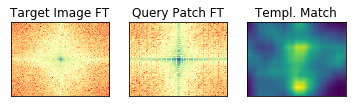

In [51]:
im2f = ft_and_show(im2g, subplt=131, newsize=im2g.shape, title='Target Image FT')
pf   = ft_and_show(pg,   subplt=132, newsize=im2g.shape, title='Query Patch FT')

temp_conj = np.conj(im2f)
ft_template_match = ift(pf*temp_conj)
print("Minimum point is :", end =" ")
print(np.unravel_index(ft_template_match[:-48,:-48].argmin(),ft_template_match.shape))
np.unravel_index(ft_template_match[:-48,:-48].argmin(),ft_template_match.shape)
plt.subplot(133),plt.imshow(1./ft_template_match),plt.title('Templ. Match')
plt.setp(plt.gcf().get_axes(),xticks=[],yticks=[]);

Recall the SSD matching function $\displaystyle E_{\mathrm{SSD}} = \sum_{i} [ I_1(x_i+u) - I_0(x_i)]^2$

If we expand it: $E_{\mathrm{SSD}} = \sum_{i}I_1(x_i+u)^2 + \sum_{i}I_0(x_i)^2 - 2\sum_{i} I_1(x_i+u)I_0(x_i)$ , note the last term - it's simply the cross-correlation!

## Dimensionality Reduction

In class we've seen the Principal Component Analysis, which may be used as a tool for dimensionality reduction.

PCA works by diagonalizing the covariance matrix of a given data-set of samples using the eigen decomposition: $cov(X) = \hat{X}\hat{X}^\top = PDP^\top$ (where $\hat{X}$ are the mean-subtracted samples). With a diagonal covariance matrix ($D$) we effectively try to find directions of zero **co-**variance (zeros outside the diagonal), but maximal variance (high values on the diagonal), which the orthogonal transformation $P$ imposes. The columns of $P$ are called the *principal components*.

We also saw that taking the SVD: $X = U\Sigma V^\top$ (instead of the eigen decomposition of $XX^\top$) can give us the same result, where the columns of $U$ are the principal components.

The SVD is a far better method, since finding the eigen decomposition of $XX^\top$ might be a very hard task. For example if the size of our images is $32\times 32 = 1024$, we'd have to calculate the eigen decomposition of a $1024\times 1024$ matrix.

### 1. Show that $XX^\top = U(\Sigma\Sigma^\top)U^\top$ (which is similar to $PDP^\top$)

$X = U\Sigma V^\top$

$XX^\top = U\Sigma V^\top X^\top$

$XX^\top = U\Sigma V^\top (U\Sigma V^\top)^\top$

$XX^\top = U\Sigma V^\top V\Sigma^\top U^\top$

$XX^\top = U\Sigma I \Sigma^\top U^\top$

$XX^\top = U(\Sigma\Sigma^\top) U^\top$

### 2. Perform the PCA transformation for the given small dataset of faces. 
    
* Flatten the images to 48$\times$48 = 2304 vectors (use `.reshape()`)
* Subtract the mean vector from all the samples. (use `np.mean()`)
* Use `u,_,_ = np.linalg.svd`.
* Show the first 10 principal components.
* Reconstruct sample index 90 using just the first \[10,20,50,100\] components and compute the RMSD to the original sample. (this can be done by `np.matmul` of the sample vector and a subset of $U$,`u` columns)
* Show the effect of applying the first 10 PCs

Follow the instructions below.

Faces dataset adapted from: https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

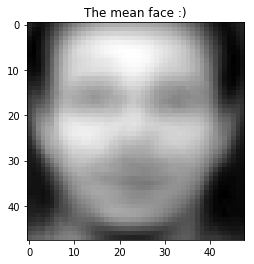

In [10]:
# download and load the dataset into a numpy array
import requests
from io import BytesIO
dataset_zip = 'https://drive.google.com/uc?export=download&id=1zwdkL1hVRD6BKksZM4sLloFxBTiEPtxT'
faces = np.load(BytesIO(requests.get(dataset_zip).content))['faces']
plt.imshow(np.mean(faces, axis=0), cmap='gray'),plt.title('The mean face :)');

Flatten the face samples to 1D vectors

In [11]:
faces_flat = faces.flatten().reshape(400, 2304)

In [12]:
print(faces_flat.shape) # make sure shape is correct

(400, 2304)


Calculate and subtract the mean (`np.mean`) from the faces. You may override `faces_flat`.

In [13]:
faces_mean=np.mean(faces_flat,axis=0)
faces_flat=faces_flat-faces_mean

In [14]:
# make sure the mean is now 0
print(np.linalg.norm(np.mean(faces_flat, axis=0)))

8.091146717284245e-13


Calculate the SVD of `faces_flat.T` (use `np.linalg.svd`)

In [15]:
u,z,_= np.linalg.svd(faces_flat.T)

Show the first 10 principal components (columns of $U$).

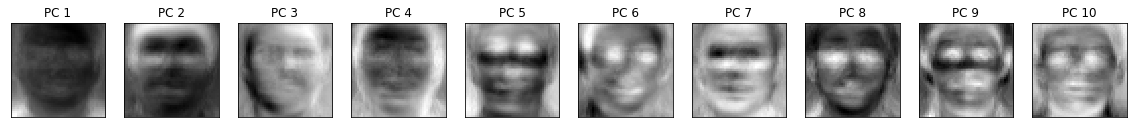

In [16]:
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(1,10,i+1),plt.imshow(u[:,i].reshape(faces[0].shape), cmap='gray'),plt.title('PC %d'%(i+1))
plt.setp(plt.gcf().get_axes(),xticks=[],yticks=[]);

Reconstruct sample index 90 (in `faces_flat`) using \[10,20,50,100\] PCs

In [17]:
def reconstruct(image_v, u, n_pc):
    projected = np.matmul(image_v, u[:, :n_pc])
    
    # reconstruct, start from the mean face
    reconstructed = faces_mean.copy()
    
    # iteratively *add* the PC (column of u, e.g. u[:,i]) with the scaling from `projected` (e.g. projected[i])
    for i,lmb in enumerate(projected):
        reconstructed += u[:,i]*lmb
    return reconstructed

Repeat for the amounts of PCs for reconstruction:

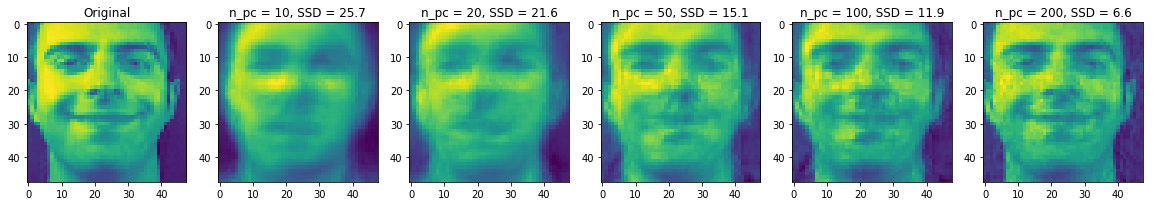

In [18]:
# show the reconstruction and the RMSD
plt.figure(figsize=(20,10))
plt.subplot(161),plt.imshow(faces[90]),plt.title('Original')
for i,n_pc in enumerate([10,20,50,100,200]):
    reconstructed = reconstruct(faces_flat[90], u, n_pc)
    plt.subplot(1,6,i+2),plt.imshow(reconstructed.reshape(faces[0].shape))
    rmsd = np.std(np.subtract(reconstructed, faces[90].reshape(faces_mean.shape))) 
    plt.title('n_pc = %d, SSD = %.1f'%(n_pc, rmsd));

Show the effect of the first 10 PCs on the mean face. For each PC show the +5,-5 standard deviation (`5.0 * np.sqrt(z[i])`).

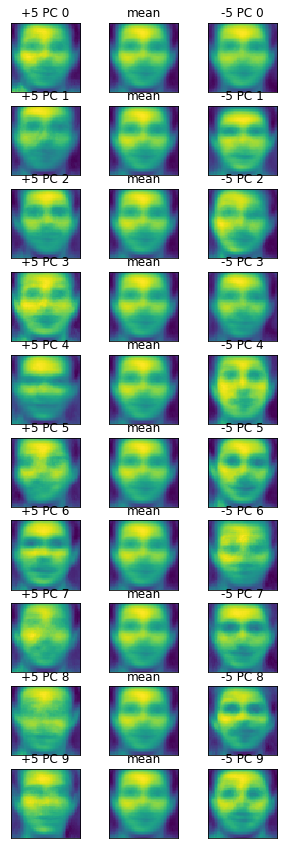

In [19]:
plt.figure(figsize=(5,15))
for i in range(10):
    face_warp_plus  = faces_mean + u[:,i]*5.0*np.sqrt(z[i])
    face_warp_minus = faces_mean - u[:,i]*5.0*np.sqrt(z[i])
    plt.subplot(10,3,i*3+1),plt.imshow(face_warp_plus.reshape((48,48))),plt.title('+5 PC %d'%i)
    plt.subplot(10,3,i*3+2),plt.imshow(faces_mean.reshape((48,48))),plt.title('mean')
    plt.subplot(10,3,i*3+3),plt.imshow(face_warp_minus.reshape((48,48))),plt.title('-5 PC %d'%i)
plt.setp(plt.gcf().get_axes(),xticks=[],yticks=[]);

See how some PCs alter a "trait" of the face, e.g. "looking right-left" (PC \#5), "taller-shorter face" (PC \#9), "raise eyebrows" (PC \#4) etc. Other, more powerful, dimensionality reduction methods we will see in the future can use this feature.

### Object Detection using PCs
We can also use the PCs to find the face in the image.

Scan the image and try to reconstruct using the first 10 PCs.

In [20]:
detection_im = np.zeros((im1g.shape[0]-48, im1g.shape[1]-48), np.float32)
for p in product(range(im1g.shape[0]-48),range(im1g.shape[1]-48)):
    patch = im1g[p[0]:p[0]+48,p[1]:p[1]+48] # take a 48x48 patch
    reconstructed = reconstruct(patch.reshape(faces_mean.shape), u, 10)
    detection_im[p] = np.std(np.subtract(reconstructed, patch.reshape(faces_mean.shape)))

In [21]:
# find the highest detection point using '.argmax()'
detection_pt = np.unravel_index((1./detection_im).argmax(), detection_im.shape)

Show the highest ranking detected patch

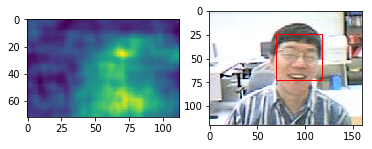

In [22]:
plt.subplot(121),plt.imshow(1./detection_im)
plt.subplot(122),plt.imshow(cv2.rectangle(im1.copy(), (detection_pt[1], detection_pt[0]), (detection_pt[1]+48,detection_pt[0]+48), (255,0,0)));

## Good Features To Track and Lucas-Kanade Optical Flow

1. Find "good features to track" using the Shi & Tomasi criterion: $\min(\lambda_1,\lambda_2)<\lambda_t$, where the lambdas are the eigenvalues of the autocorrelation matrix $A$.
2. Find features using the harmonic mean criterion: $\displaystyle\frac{\det A}{\mathrm{tr} A}$ (instead of an eigen decomposition of $A$)

Recall the autocorrelation matrix is 
$$
A=\nabla I \nabla I^\top=\begin{pmatrix} \sum I_x^2 & \sum I_x I_y \\ \sum I_x I_y & \sum I_y^2 \end{pmatrix}
$$
where $I_x,I_y$ are image derivatives (e.g. `cv2.Sobel`). The summation can be taken with a simple Gaussian window (convolution, `cv2.GaussianBlur`).

Then, for the features that pass the threshold test, calculate the Lucas-Kanade/Horn-Schnuck optical flow that arises from the following: $I_xu + I_yv + I_t = 0$, where $I_t$ is the derivative in **time**.
$$
A^\top Ax = A^\top b \Rightarrow \begin{bmatrix} \sum I_x^2 & \sum I_x I_y \\ \sum I_x I_y & \sum I_y^2 \end{bmatrix}
\begin{pmatrix}u\\v\end{pmatrix}=
\begin{bmatrix}-\sum I_x I_t \\ -\sum I_y I_t\end{bmatrix}
$$

In [23]:
# calculate image derivatives: ix, iy, ixy, as well as ixx = ix**2, iy = iy**2
# e.g. `ix  = cv2.Sobel(im1g, cv2.CV_32F, 1, 0)`
ix = cv2.Sobel(im1g, cv2.CV_32F, 1, 0)
iy = cv2.Sobel(im1g, cv2.CV_32F, 0, 1)
ixx = cv2.GaussianBlur(ix*ix, (3,3), 0)
iyy = cv2.GaussianBlur(iy*iy, (3,3), 0)
ixy = cv2.GaussianBlur(ix*iy, (3,3), 0)
gix = cv2.GaussianBlur(ix, (3,3), 0)
giy = cv2.GaussianBlur(iy, (3,3), 0)
# don't forget to perform a `cv2.GaussianBlur`! e.g. gix = cv2.GaussianBlur(ix, ...)

Show image derivatives

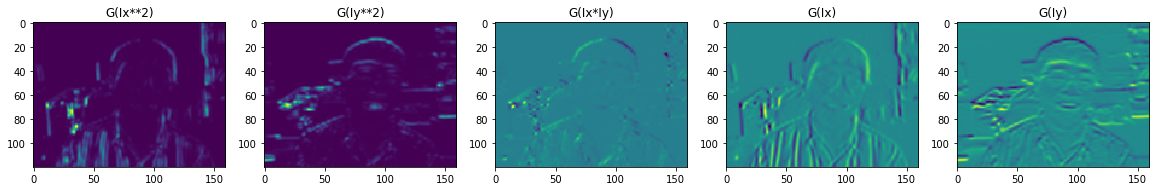

In [24]:
plt.figure(figsize=(20,10))
plt.subplot(151),plt.imshow(ixx),plt.title("G(Ix**2)");
plt.subplot(152),plt.imshow(iyy),plt.title("G(Iy**2)");
plt.subplot(153),plt.imshow(ixy),plt.title("G(Ix*Iy)");
plt.subplot(154),plt.imshow(gix),plt.title("G(Ix)");
plt.subplot(155),plt.imshow(giy),plt.title("G(Iy)");

Calculate $A$'s eigenvalues and det/tr in each pixel:

In [25]:
ixxr,iyyr,ixyr = ixx.ravel(),iyy.ravel(),ixy.ravel() # flatten to 1D for ease of iteration
im_eig = np.zeros_like(ixxr)
im_det_tr = np.zeros_like(ixxr)

for i in range(ix.size):
    # construct A matrix
    A = np.array([[ixxr[i], ixyr[i]],[ixyr[i], iyyr[i]]])
    # take eigen decomposition, e.g. `d,p = np.linalg.eig(...)`
    d,p = np.linalg.eig(A)
    # find the minimal EV, e.g. `im_eig[i] = np.min(..)`
    im_eig[i] = np.min(d)
    if A.trace() != 0.0:
        im_det_tr[i] = np.linalg.det(A) / A.trace()
    else:
        im_det_tr[i] = 0.0
    
im_eig = np.abs(im_eig).reshape(im1g.shape) # reshape back to 2D
im_det_tr = np.abs(im_det_tr).reshape(im1g.shape) # reshape back to 2D

To get corners we apply non-maximal suppression:

In [26]:
# a small utility to do Non-Maximal Suppression to get the actual corner points
# returns a list[(y0,x0), (y1,x1), (y2,x2), ...]
def cornersNonMaxSuppressionAndThreshold(im, thresh, nms_kernel=(7,7)):
    ima_d = cv2.dilate(im,np.ones(nms_kernel,np.uint8))
    corners_im = np.all([(im > thresh).ravel(), (im == ima_d).ravel()], axis=0).reshape(im.shape).astype(np.uint8)
    _,corners_ctrs,_ = cv2.findContours(corners_im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    corners = [np.mean(ctr, axis=0) for ctr in corners_ctrs]
    corners = np.flip(np.squeeze(np.array(corners)).astype(np.int32), 1)
    return corners, corners_im

In [27]:
# get the corner points
corners_eig, corners_im_eig = cornersNonMaxSuppressionAndThreshold(im_eig, 3000)
corners_det_tr, corners_im_det_tr = cornersNonMaxSuppressionAndThreshold(im_det_tr, 3000)

Show the detected corners

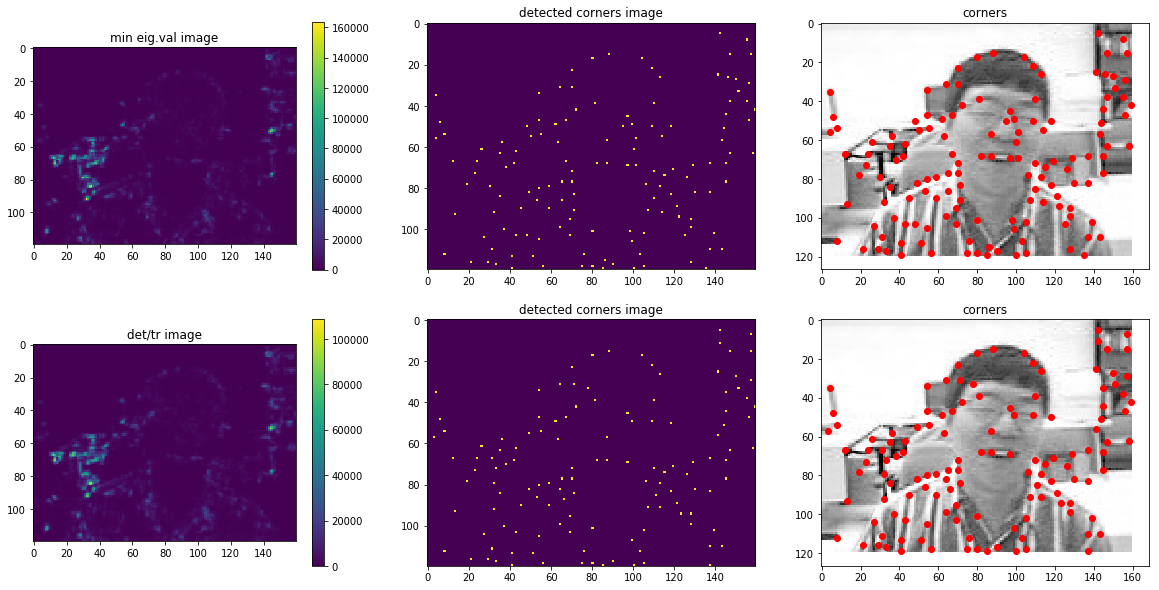

In [28]:
plt.figure(figsize=(20,10))
plt.subplot(231),plt.imshow(im_eig),plt.colorbar(),plt.title('min eig.val image')
plt.subplot(232),plt.imshow(corners_im_eig),plt.title('detected corners image')
plt.subplot(233),plt.imshow(im1g, cmap='gray'),plt.scatter(corners_eig[:,1],corners_eig[:,0], c='r'),plt.title('corners');
plt.subplot(234),plt.imshow(im_det_tr),plt.colorbar(),plt.title('det/tr image')
plt.subplot(235),plt.imshow(corners_im_det_tr),plt.title('detected corners image')
plt.subplot(236),plt.imshow(im1g, cmap='gray'),plt.scatter(corners_det_tr[:,1],corners_det_tr[:,0], c='r'),plt.title('corners');

### Tracking the corners with L-K optical flow

In [29]:
# calculate the It
it = cv2.GaussianBlur(np.float32(im1g)-im2g, (3,3), 0) 
ixit = cv2.GaussianBlur(ix * it, (3,3), 0)
iyit = cv2.GaussianBlur(iy * it, (3,3), 0)

The L-K OF poses an $Ax=b$ linear system from $\nabla I$ and $\nabla t$ (shown above). Solve it for every pixel to obtain the local motion.

In [30]:
uv = np.zeros((0,2))
for p in corners_eig:
    p = tuple(p)
    A = np.array([[ixx[p], ixy[p]],[ixy[p], iyy[p]]])
    b = np.array([[-ixit[p]],[-iyit[p]]])
    p_uv = np.linalg.solve(A,b)
    uv = np.vstack([uv, np.squeeze(p_uv)]) # append uv to list

Show the movement vectors:

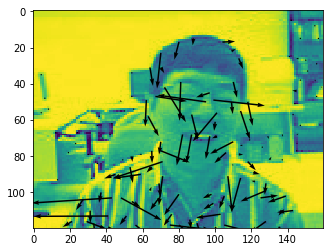

In [31]:
plt.imshow(im1g),plt.quiver(corners_eig[:,1],corners_eig[:,0],uv[:,1],uv[:,0]);

You've implemented an Optical Flow algorithm from scratch - how cool is that?

You may want to compare your results to OpenCV's `cv2.cornersMinEigenVal`, `cv2.goodFeaturesToTrack` and `cv2.calcOpticalFlowPyrLK`

---

## Segmentation with Normalized Cuts

In 2000 Shi & Malik introduced the Normalized Cuts method for segmentation. Over the years it garnered over **15,000 citations** -- that's huge!

The method relies on the notion of cutting the graph (image divided to nodes) not by finding the minimal cut in terms of edge weight (e.g. color/texture similarity), but by balancing the cut weight and the **assiciation weight**, which is the internal likeliness of the nodes within the segment.

We will implement a simple norm-cut method here, since the full method is heavily involved.

For more details see the paper: Shi, Jianbo, and Jitendra Malik. *"Normalized Cuts and Image Segmentation."* IEEE Transactions on Pattern Analysis and Machine Intelligence (TPAMI) 22.8 (2000). (be warned, it is heavy on the math)

In [32]:
# Utilities we're going to need

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from matplotlib.lines import Line2D
import scipy

# Calculate the SLIC superpixels, their histograms and neighbors
def superpixels_histograms_neighbors(img):
    # SLIC
    segments = slic(img, n_segments=500, compactness=20)
    segments_ids = np.unique(segments)

    # centers
    centers = np.array([np.mean(np.nonzero(segments==i),axis=1) for i in segments_ids])

    # H-S histograms for all superpixels
    hsv = cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2HSV)
    bins = [10, 10, 10] # H = S = 20
    ranges = [0, 360, 0, 1, 0, 1] # H: [0, 360], S: [0, 1]
    colors_hists = np.float32([cv2.calcHist([hsv],[0, 1, 2], np.uint8(segments==i), bins, ranges).flatten() for i in segments_ids])
    # normalize the histograms
    colors_hists = np.float32([h / h.sum() for h in colors_hists])
    
    # neighbors via right-and-down lookup
    neighbors_vs = np.hstack([np.vstack([segments[:,:-1].ravel(),segments[:,1:].ravel()]),
                              np.vstack([segments[:-1,:].ravel(),segments[1:,:].ravel()])])
    bneighbors = np.unique(np.sort(neighbors_vs, axis=0), axis=1)
    
    return (centers,colors_hists,segments,bneighbors)

# Get a bool mask of the pixels for a given selection of superpixel IDs
def pixels_for_segment_selection(superpixels_labels, selection):
    pixels_mask = np.where(np.isin(superpixels_labels, selection), True, False)
    return pixels_mask

# draw the image, segments boundaries and neighbors
def show_superpixels_neighbors(img, segments, centers, neighbors, W=None):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    plt.imshow(mark_boundaries(img, segments))
    plt.scatter(centers[:,1],centers[:,0], c='y')

    for i in range(neighbors.shape[1]):
        n,m = neighbors[0,i],neighbors[1,i]
        y0,x0 = centers[n]
        y1,x1 = centers[m]

        color = plt.cm.jet(W[n,m] / 25.) if W is not None else 'b'
        ax.add_line(Line2D([x0,x1],[y0,y1], alpha=0.5, color=color))
        

* Load the image
* Find the SLIC superpixels
* Find neighbors on the graph imposed by the superpixels
* Calculate color histograms for each superpixel

In [33]:
from skimage.data import astronaut
img = astronaut().astype(np.float32) / 255.

Get the superpixels and histograms:

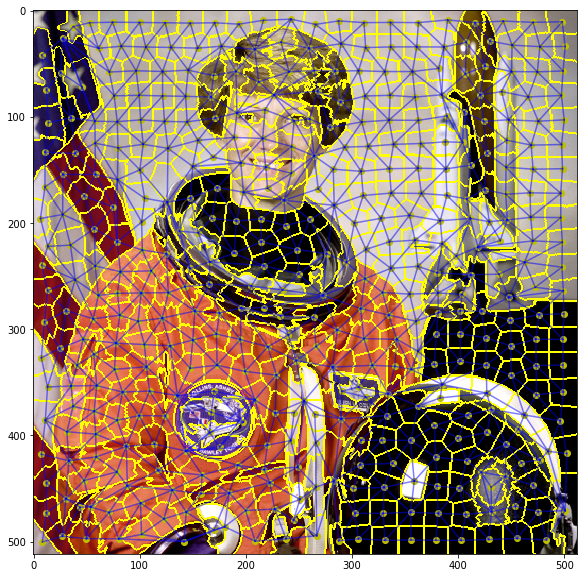

In [34]:
centers, colors_hists, segments, neighbors = superpixels_histograms_neighbors(img)
show_superpixels_neighbors(img, segments, centers, neighbors)

Build a (symmetric) weight matrix $W(i,j) = D_\mathrm{KL}(H_i \, || \, H_j)$, where $D_\mathrm{KL}(P||Q)$ is the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) (a metric for distance between PDFs, in this case - histograms).

Since the KLD measures *divergence*, we would like to reverse it, that way we get higher weights for stronger connections and lower weights for weaker connections. In your calculation (using `cv2.compareHist`) use the `cv2.HISTCMP_KL_DIV` and subtract that from **25**. E.g. `25 - cv2.compareHist(...)`

Then build a matrix $D$ with $d_i = \sum_j W(i,j)$ (essentially `np.sum` the rows of $W$) on the diagonal (`np.diag`).

In [35]:
num_nodes = colors_hists.shape[0]
W = np.zeros((num_nodes,num_nodes),np.float32)
D = np.zeros((num_nodes,num_nodes),np.float32)

for i in range(neighbors.shape[1]):
    n,m = neighbors[0,i],neighbors[1,i]
    hn = colors_hists[n] # histogram for superpixel
    hm = colors_hists[m] # histogram for neighbor
    W[n,m] = 25 - cv2.compareHist(hn, hm, cv2.HISTCMP_KL_DIV)
    W[m,n] = 25 - cv2.compareHist(hm, hn, cv2.HISTCMP_KL_DIV) # also calculate the symmetric edge
for i in range(len(W[0])):
    D[i][i] = np.sum(W[:,i])

Verify your results

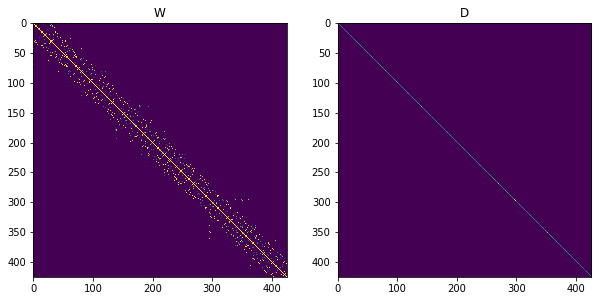

In [36]:
plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(W),plt.title('W')
plt.subplot(122),plt.imshow(D),plt.title('D');

We can visualize the edges weights on the graph as well: (you can visually see a "minimal cut")

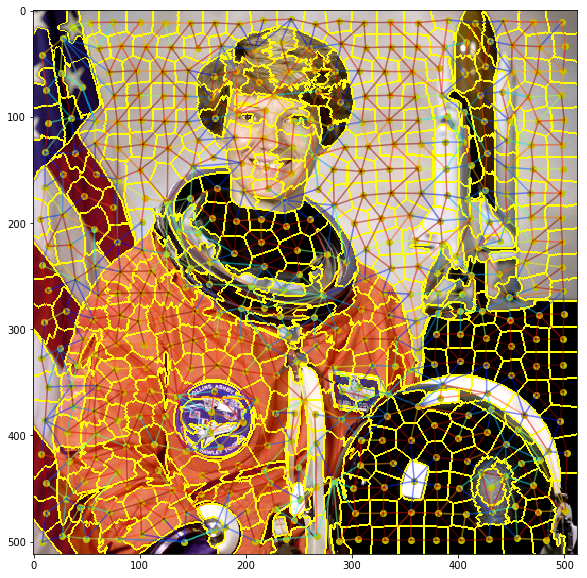

In [37]:
show_superpixels_neighbors(img, segments, centers, neighbors, W)

According to the paper we solve a [Generalized Eigenvalue](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix#Generalized_eigenvalue_problem) problem: $(D-W)v=\lambda Dv$. 

The second-smallest eigen vector (and the others as well) will provide an indicator vector $X=(\dots, x_i \in \{-1,1\}, \dots) $ that will tell us which nodes belong to segment A ($x_i=1$) and others in segment B ($x_i=-1$). 

To determine the best threshold on the values of the eigenvector (which are continuous, and not $\{-1,1\}$) we will calculate the $N_\mathrm{cut}$:
$$
N_\mathrm{cut}=\frac{cut(A,B)}{assoc(A,V)}+\frac{cut(B,A)}{assoc(B,V)} = \frac{\sum_{(x_i>0,x_j<0)}w_{ij}}{\sum_{(x_i>0)}d_i} + \frac{\sum_{(x_i<0,x_j>0)}w_{ij}}{\sum_{(x_i<0)}d_i}
$$
And take the threshold value that has the minimal $N_\mathrm{cut}$.

In [38]:
evs, evecs = scipy.linalg.eig(D-W, D)

Implement the `Ncut` function to calculate `cutAB`,`cutBA`,`assocAV`,`assocBV` from `W` and `d`. 

Remember: $W(i,j)$ when $(x_i>0,x_j<0)$ should be added to `cutAB`, the opposite should be added to `cutBA`.

In [39]:
def Ncut(X,W):
    d = np.sum(W, axis=0)
    cutAB = cutBA = 0
    assocAV = assocBV = 0
    for i in range(len(X)):
        if X[i] > 0:
            assocAV = assocAV + d[i]
        if X[i] < 0:
            assocBV = assocBV + d[i]
        for j in range(i+1, len(X)):
            if X[i] > 0 and X[j] < 0:
                cutAB = cutAB + W[i][j]
            if X[i] < 0 and X[j] > 0:
                cutBA = cutBA + W[i][j]
    return cutAB/assocAV + cutBA/assocBV

Find the minimal-Ncut threshold value by scanning the second-smallest eigenvector.

Using a brute-force method, check 20 equally distributed threshold-values on the range [`ev.min()`,`ev.max()`], using `np.linspace(mn,mx,20)`.

To turn the real-valued eigenvector to a $\{-1,1\}$ indicator vector use `np.int32((np.float32(ev > thresh) - 0.5) * 2)`

For each threshold-value, calculate Ncut using `Ncut()` and store the Ncut-value along with the checked threshold-value, e.g. `thresh_ncut += [[thresh_val, ncut_val]]`.

In [40]:
second_ev = evecs[:,evs.argsort()[1]] # take the second-smallest evec
thresh_ncut = []
for thresh_val in np.linspace(second_ev.min(), second_ev.max(), 20, endpoint=False):
    curr_thres = np.int32((np.float32(second_ev > thresh_val) - 0.5) * 2)
    ncut_val = Ncut(curr_thres, W)
    thresh_ncut += [[thresh_val, ncut_val]]
    
thresh_ncut = np.array(thresh_ncut)

In [41]:
# get the actual threshold value
min_thr = thresh_ncut[:,1].argmin()
min_val = thresh_ncut[min_thr,0]

Plot the smallest Ncut threshold-value 

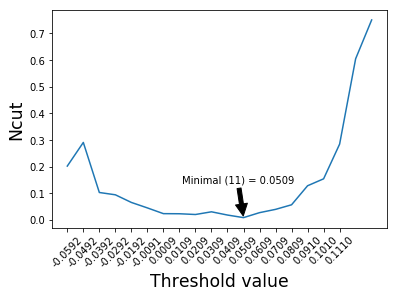

In [42]:
plt.plot(thresh_ncut[:,1])
plt.xticks(range(18),['%.4f'%t for t in thresh_ncut[:,0]], rotation=45)
plt.ylabel('Ncut',fontsize='xx-large'),plt.xlabel('Threshold value',fontsize='xx-large')
plt.annotate('Minimal (%d) = %.4f'%(min_thr,thresh_ncut[min_thr,0]), (min_thr, thresh_ncut[min_thr,1]),
             xytext=(-5, 35), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center');

Now by thresholding the eigenvector we can get the superpixels that belong to segments A and B.

Show the segmentation:

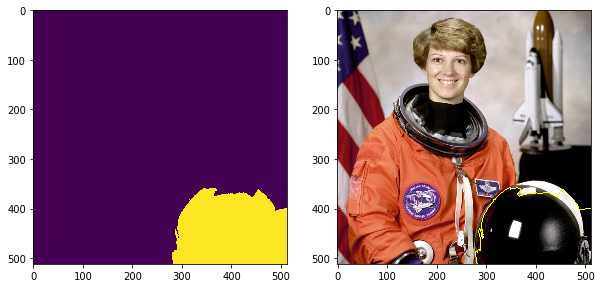

In [43]:
boundary = pixels_for_segment_selection(segments, np.nonzero(second_ev >= min_val)[0])
plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(boundary)
plt.subplot(122),plt.imshow(mark_boundaries(img, boundary, mode='thick'));

The method may be repeated in order to cut the segments further (with some threshold on $N\mathrm{cut}$).

That's a wrap!